# Assignment 3 - Part I


# Imports

In [0]:
%matplotlib inline

import os
import shutil
import urllib.request
import tarfile

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import spline
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import SGD

## Helper Functions

In [0]:
def fit_spline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    x = np.linspace(x.min(), x.max(), 10)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)    
    return x, spline(x)

In [0]:
def plot_model_hist(model, metrics, smooth=False):
    
    # Get metrics to plot
    _y = np.array(model.history.history[metrics])
    _y_val = np.array(model.history.history['val_' + metrics])
    _x = np.linspace(0, _y.shape[0] - 1, _y.shape[0]) # No of epochs
    
    # Smooth
    if smooth:
        _, _y = fit_spline(_x, _y)
        _x, _y_val = fit_spline(_x, _y_val)
    
    plt.plot(_x, _y, 'g')
    plt.plot(_x, _y_val, 'r')
    plt.title('Loss through time' if metrics == 'loss' else 'Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss' if metrics == 'loss' else 'Accuracy')
    plt.grid('off')
    plt.legend(['train', 'test'], loc='upper right' if metrics == 'loss' else 'upper left')

# Getting Started

In [0]:
# Constants
ZIP_NAME = 'Outex_TC_00030.tar.gz'
IMG_DIR = os.path.join('Outex-TC-00030', 'images')
TRAIN_TXT = os.path.join('Outex-TC-00030', '000', 'test.txt') # Test and Train switched on purpose
TEST_TXT = os.path.join('Outex-TC-00030', '000', 'train.txt')
TRAIN_DIR = os.path.join('dataset', 'train')
TEST_DIR = os.path.join('dataset', 'test')

## Download dataset

In [5]:
# Download dataset
if not os.path.isfile(ZIP_NAME):
    print('Downloading %s' % ZIP_NAME)
    urllib.request.urlretrieve('http://lagis-vi.univ-lille1.fr/datasets/Outex_TC_00030.tar.gz', ZIP_NAME)
else:
    print('%s found on filesystem.' % ZIP_NAME)

In [6]:
# Extract
print('Extracting %s' % ZIP_NAME)
with tarfile.open(ZIP_NAME, "r:gz") as t:
    t.extractall()

Extracting Outex_TC_00030.tar.gz


## Organize Images
Copy files into a structure suitable for ImageDataGenerator

In [0]:
# Parse text file
def parse_txt(txt_path):
    result = []
    with open(txt_path, 'r') as f:
        f.readline() # Drop first line
        for line in f:
            # Parse filename and class
            result += [line.split()]
    return np.array(result)

In [0]:
# Copies images into appropriate directory
def copy_images(result, dest_dir):
    for img_path, img_cls in result:
        os.makedirs(os.path.join(dest_dir, img_cls), exist_ok=True) # Create directory for class if it doesn't exist
        shutil.copy(os.path.join(IMG_DIR, img_path), os.path.join(dest_dir, img_cls)) # Copy file

In [9]:
# Start from a clean slate
shutil.rmtree(TRAIN_DIR, ignore_errors=True)
shutil.rmtree(TEST_DIR, ignore_errors=True)

# Create dirs
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Parse and copy train images
copy_images(parse_txt(TRAIN_TXT), TRAIN_DIR)

# Parse and copy test images
copy_images(parse_txt(TEST_TXT), TEST_DIR)

print('Images organized into train and test directory')

Images organized into train and test directory


## Load images using ImageDataGenertor

In [10]:
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(TRAIN_DIR, target_size=(128, 128), batch_size=32)

Found 10880 images belonging to 68 classes.


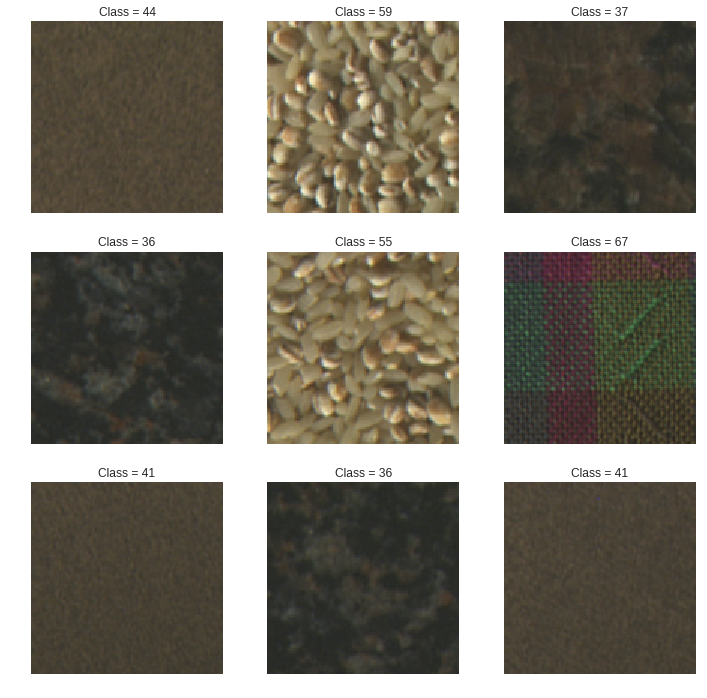

In [11]:
# Visualize images from the dataset
x, y = next(train_gen)

plt.gcf().set_size_inches(12, 12)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.title('Class = %d' % np.argmax(y[i]))
    plt.axis('off')
    plt.imshow(x[i], interpolation="nearest")

plt.show()

In [12]:
# Get number of classes
NUM_CLASSES = np.unique(train_gen.classes).shape[0]
print('NUM_CLASSES = %d' % NUM_CLASSES)

NUM_CLASSES = 68


# VGG-16

In [13]:
# Image Generators
IMG_SIZE = 128
train_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input).flow_from_directory(TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=32)
test_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input).flow_from_directory(TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=32)

Found 10880 images belonging to 68 classes.
Found 1360 images belonging to 68 classes.


In [14]:
# Load VGG Model
vgg_model = VGG16(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool

In [0]:
# Freeze layers
for layer in vgg_model.layers:
    layer.trainable = False    

In [16]:
# Create a new model

x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model = Model(inputs=vgg_model.input, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit_generator(train_gen, epochs=10, validation_data=test_gen, verbose=1)

Epoch 1/10
340/340 [==============================] - 43s 125ms/step - loss: 2.7619 - acc: 0.3439 - val_loss: 1.8333 - val_acc: 0.5213
Epoch 2/10
340/340 [==============================] - 38s 112ms/step - loss: 1.4661 - acc: 0.5865 - val_loss: 1.2417 - val_acc: 0.6346
Epoch 3/10
340/340 [==============================] - 38s 111ms/step - loss: 1.0856 - acc: 0.6734 - val_loss: 0.9859 - val_acc: 0.7081
Epoch 4/10
340/340 [==============================] - 38s 112ms/step - loss: 0.8787 - acc: 0.7367 - val_loss: 0.8425 - val_acc: 0.7338
Epoch 5/10
340/340 [==============================] - 38s 112ms/step - loss: 0.7565 - acc: 0.7642 - val_loss: 0.7387 - val_acc: 0.7691
Epoch 6/10
340/340 [==============================] - 38s 112ms/step - loss: 0.6664 - acc: 0.7888 - val_loss: 0.6848 - val_acc: 0.7610
Epoch 7/10
340/340 [==============================] - 38s 111ms/step - loss: 0.5984 - acc: 0.8108 - val_loss: 0.6039 - val_acc: 0.8029
Epoch 8/10
340/340 [==============================] - 3

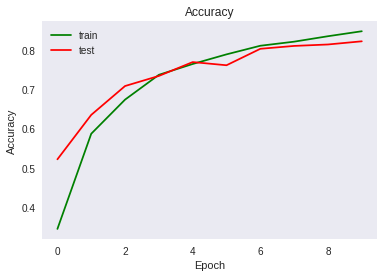

In [19]:
plot_model_hist(model, 'acc')

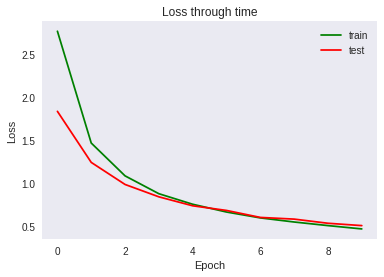

In [20]:
plot_model_hist(model, 'loss')

## Fine Tuning
Retraining some of the higer layers to improve performance

In [0]:
# Unfreeze last block
for layer in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
    model.get_layer(layer).trainable = True

In [0]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit_generator(train_gen, epochs=20, validation_data=test_gen, verbose=1)

Epoch 1/20
340/340 [==============================] - 44s 129ms/step - loss: 0.4318 - acc: 0.8420 - val_loss: 0.3720 - val_acc: 0.8699
Epoch 2/20
340/340 [==============================] - 43s 127ms/step - loss: 0.3264 - acc: 0.8783 - val_loss: 0.3048 - val_acc: 0.8882
Epoch 3/20
340/340 [==============================] - 43s 127ms/step - loss: 0.2772 - acc: 0.8955 - val_loss: 0.3299 - val_acc: 0.8787
Epoch 4/20
340/340 [==============================] - 43s 127ms/step - loss: 0.2476 - acc: 0.9071 - val_loss: 0.2847 - val_acc: 0.9000
Epoch 5/20
340/340 [==============================] - 43s 126ms/step - loss: 0.2218 - acc: 0.9192 - val_loss: 0.2810 - val_acc: 0.8963
Epoch 6/20
340/340 [==============================] - 43s 127ms/step - loss: 0.2123 - acc: 0.9188 - val_loss: 0.2624 - val_acc: 0.8926
Epoch 7/20
340/340 [==============================] - 43s 127ms/step - loss: 0.1977 - acc: 0.9250 - val_loss: 0.3290 - val_acc: 0.8772
Epoch 8/20
340/340 [==============================] - 4

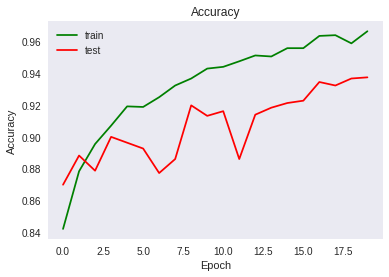

In [24]:
plot_model_hist(model, 'acc')

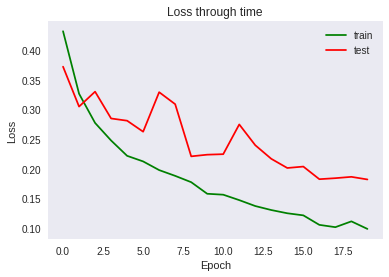

In [25]:
plot_model_hist(model, 'loss')